In [456]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kstest
from scipy.stats import wilcoxon
from scipy.stats import mannwhitneyu

In [2]:
psrc_survey_path = 'G:\\My Drive\\2021\\Bias\\PSRC Spring 2017 Travel Survey\\2017-pr1-data-files-no-GPS\\'
os.chdir(psrc_survey_path)

In [278]:
hh = pd.read_excel('2017-pr1-1-household.xlsx', header=1)
selected_hh_col = ['hhid', 'final_home_tract','final_home_bg','final_home_taz2010','prev_home_taz2010',
                   'hhincome_detailed', 'hhincome_followup','hhincome_broad', 'hh_wt_final']
hh = hh[selected_hh_col]

person = pd.read_excel('2017-pr1-2-person.xlsx', header=1)
selected_columns_p = ['hhid', 'personid', 'sample_segment', 'age', 'gender', 'employment',
                      'smartphone_type','smartphone_age','smartphone_qualified','mobile_device',
                      'call_center','education','hh_wt_final']
person = person[selected_columns_p]


#check person with GPS and person w.o GPS, the infomation is the same
#hh_GPS = pd.read_excel('..\\2017-pr1-data-files-GPS\\2017-pr1-R-1-household.xlsx', header=1)
#hh_GPS = hh_GPS[selected_hh_col]
#hh_GPS.columns

#person_GPS = pd.read_excel('..\\2017-pr1-data-files-GPS\\2017-pr1-R-2-person.xlsx', header=1)
#person_GPS = person[selected_columns_p]
#person_GPS.head(3)

#del(person_GPS, hh_GPS)

In [279]:
person.groupby(by=['smartphone_type', 'smartphone_qualified']).count()

hhid  personid  sample_segment   age  \
smartphone_type smartphone_qualified                                         
1.0             0                      225       225             225   225   
                1                     1576      1576            1576  1576   
2.0             0                      311       311             311   311   
                1                     2518      2518            2518  2518   
3.0             0                      160       160             160   160   
4.0             0                       10        10              10    10   
5.0             0                       52        52              52    52   
6.0             0                      549       549             549   549   

                                      gender  employment  smartphone_age  \
smartphone_type smartphone_qualified                                       
1.0             0                        225         225             225   
                1                       1576        1576            1576   
2.0             0                        311         311             311   
                1                       2518        2518            2518   
3.0             0                        160         160               0   
4.0             0                         10          10               0   
5.0             0                         52          52               0   
6.0             0                        549         549               0   

                                      mobile_device  call_center  education  \
smartphone_type smartphone_qualified                                          
1.0             0                               225          225        225   
                1                              1499         1499       1576   
2.0             0                               311          311        311   
                1                              2403         2403       2518   
3.0             0                               160          160        160   
4.0             0                                10           10         10   
5.0             0                                52           52         52   
6.0             0                               549          549        549   

                                      hh_wt_final  
smartphone_type smartphone_qualified               
1.0             0                             225  
                1                            1568  
2.0             0                             311  
                1                            2505  
3.0             0                             160  
4.0             0                              10  
5.0             0                              52  
6.0             0                             549

In [593]:
#decode the data
#for age, pagey
#<18, 18-29, 30-49, 50-64, >65
#convert demogroup
#age <18, 18-29, 30-49, 50-64, >65
def dage(x):
    if x<=4:
        return 1
    elif x==5:
        return 2
    elif x >=6 and x<=7:
        return 3
    elif x>=8 and x<=9:
        return 4
    else:
        return 5
    
#for household income, hhincome
#Poor or near-poor 32,048 or less
#Lower-middle class 32,048 - 53,413
#Middle class 53,413 - 106,827
#Upper-middle class 106,827 - 373,894
#Rich 373,894 and up
def decode_income_pew(income_var):
    if income_var<=4:
        return 1
    elif income_var==5:
        return 2
    elif income_var>5 and income_var<=10:
        return 3
    else:
        return(-1)
    
def decode_income_3level(income_var):
    if income_var>=1 and income_var<=4:
        return 1
    elif income_var>4 and income_var<=6:
        return 2
    elif income_var>6 and income_var<=10:
        return 3   
    else:
        return -1
    
def decode_income_follow_up_3level(income_var):
    if income_var != 0:
        if income_var >0 and income_var<=2:
            return 2
        elif income_var>=3 and income_var<=4:
            return 3
        elif income_var==5:
            return 4
        else:
            return -1
    else:
        return 0
     
        
def decode_income_follow_up_pew(income_var):
    if income_var != 0:
        if income_var >0 and income_var<=2:
            return 2
        elif income_var==3:
            return 3
        elif income_var>=4 and income_var<6:
            return 4
        else:
            return -1
    else:
        return 0

In [541]:
np.unique(hh['hhincome_detailed'])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int64)

In [281]:
#data procesisng and demographic factors decoding
person['deage'] = person['age'].apply(lambda x: dage(x))
hh['deincomepew'] = hh['hhincome_detailed'].apply(lambda x: decode_income_pew(x))

hh['hh_wt_final'] = hh["hh_wt_final"].replace(np.nan, 0)
conver_nan2zero = lambda x: 0 if type(x) == str else x
hh['hh_wt_final'] = hh['hh_wt_final'].apply(conver_nan2zero)

#checl of people who give income info has any other value after income follow-up
#np.sum(hh['hhincome_followup'][hh['hhincome_detailed']!=11])
#answer: no, the sum is 0

hh['hhincome_followup'] = hh['hhincome_followup'].replace(np.nan, 0)
hh['hhincome_followup'] = hh['hhincome_followup'].apply(conver_nan2zero)
hh['deincome_followup'] = hh['hhincome_followup'].apply(lambda x: decode_income_(x))
hh['deincome_followup'] = hh['deincomepew']+hh['deincome_followup']

In [597]:
hh['deincome3'] = hh['hhincome_detailed'].apply(lambda x:decode_income_3level(x))
hh['hhincome_followup'] = hh['hhincome_followup'].replace(np.nan, 0)
hh['hhincome_followup'] = hh['hhincome_followup'].apply(conver_nan2zero)
#person = person.drop(columns = ['deincome3'])
hh['deincome_followup3'] = hh['hhincome_followup'].apply(lambda x: decode_income_follow_up_3level(x))

In [598]:
hh['deincome_followup3'] = hh['deincome3']+hh['deincome_followup3']

In [599]:
demo_dt = person.merge(hh, how='left')
demo_dt['deincome_followup'].describe()

#smartphone index
decode_smartphone = lambda x: 0 if x in [-1, 6] else 1
demo_dt['sm_index'] = demo_dt['smartphone_type'].apply(decode_smartphone)

In [600]:
demo_dt['deincome_followup3'].describe()

count    6228.000000
mean        1.952633
std         1.371849
min        -2.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         3.000000
Name: deincome_followup3, dtype: float64

In [284]:
conver_nan2neg = lambda x: -1 if type(x) == str else x
demo_dt['smartphone_type'] = demo_dt['smartphone_type'].replace(np.nan, -1)
demo_dt['smartphone_type'] = demo_dt['smartphone_type'].apply(conver_nan2neg)
#if no smartphone info is given from smartphone type
#the other smartphone info is also unknow
#(demo_dt[['smartphone_age', 'smartphone_qualified']][demo_dt['smartphone_type']==-1]).describe()

#gender check
#check # of person whose gender is not known based on the data
#demo_dt[['gender', 'hh_wt_final']].groupby(by=['gender']).sum().values
#array([[1801775.74314757],
#       [1875038.9676913 ],
#       [   2181.58382136],
#       [ 151469.79511318]])
#unknown pop: 2181.58382136+151469.79511318

In [180]:
np.sum(demo_dt['hh_wt_final'][demo_dt['deincome_followup']==-2])

364198.31139101996

In [285]:
364198.31139101996/np.sum(demo_dt['hh_wt_final'])

0.09507937228927744

In [286]:
#delete the data
#all the data is connected to the phone instead of people with age < 18
np.sum(demo_dt[['hh_wt_final']][(demo_dt['smartphone_type']==-1) &
                                (demo_dt['mobile_device']!=1) &
                                (demo_dt['call_center']!=1)&
                                (demo_dt['deage']!=1)&
                                (demo_dt['deincome_followup']==-2)])

#check the taz info of the dataset
demo_dt['final_home_taz2010'] = demo_dt['final_home_taz2010'].replace(np.nan, 0)
demo_dt['prev_home_taz2010'] = demo_dt['prev_home_taz2010'].replace(np.nan, 0)

demo_dt['final_home_taz2010'] = demo_dt['final_home_taz2010'].astype(int)
demo_dt['prev_home_taz2010'] = demo_dt['prev_home_taz2010'].astype(int)
#if nan, both previous and final are nan

#get the tazs included in the PSRC survey

hh_wt_final    0.0
dtype: float64

% of smartphones in age group [0.98409162 0.95551314 0.87795273 0.69529057]
% of smartphones in age group, by tazs [0.17535743 0.56195338 0.47470285 0.24428358]


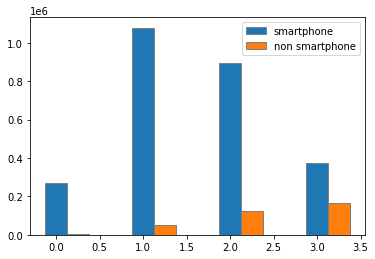

In [403]:
#since part of the income info is not known, we first check the age
age_check_dt0 = demo_dt[['sm_index', 'deage', 'hh_wt_final']][(demo_dt['deage']!=1)&(demo_dt['sm_index']==0)].groupby(by=['deage','sm_index']).sum()
age_check_dt0.reset_index(inplace=True)

age_check_dt1 = demo_dt[['sm_index', 'deage', 'hh_wt_final']][(demo_dt['deage']!=1)&(demo_dt['sm_index']==1)].groupby(by=['deage', 'sm_index']).sum()
age_check_dt1.reset_index(inplace=True)

age_check_dt = demo_dt[['sm_index', 'deage', 'hh_wt_final']][(demo_dt['deage']!=1)].groupby(by=['deage']).sum()
age_check_dt.reset_index(inplace=True)

barwidth = 0.25
br1 = np.arange(age_check_dt0.shape[0])
br2 = [x + barwidth for x in br1]

plt.bar(br1, age_check_dt1['hh_wt_final'].values, width=barwidth, 
       edgecolor = 'grey', label='smartphone')
plt.bar(br2, age_check_dt0['hh_wt_final'].values, width=barwidth, 
       edgecolor = 'grey', label='non smartphone')

plt.legend()

#smartphone % regarding different age groups
#in general
print('% of smartphones in age group', age_check_dt1['hh_wt_final'].values/age_check_dt['hh_wt_final'].values)
#print % of smartphone by age based on tazs
age_mx_all = demo_dt[['final_home_taz2010','hh_wt_final', 'deage']][(demo_dt['deage']!=1)&(demo_dt['final_home_taz2010']!=0)].groupby(by=['final_home_taz2010','deage']).sum().unstack(fill_value=0).values
test_dt = demo_dt[['final_home_taz2010','hh_wt_final','deage','sm_index']][(demo_dt['deage']!=1)&
                                                                 (demo_dt['final_home_taz2010']!=0)
                                                                ].groupby(by=['final_home_taz2010', 'deage', 'sm_index']).sum().unstack(fill_value=0).stack()

test_dt.reset_index(inplace=True)

age_mx_all[age_mx_all==0]  = 1
age_sm = test_dt[['hh_wt_final','final_home_taz2010', 'deage']][test_dt['sm_index']==1].groupby(by=['final_home_taz2010', 'deage']).sum().unstack(fill_value=0).values
print('% of smartphones in age group, by tazs', np.mean(age_sm/age_mx_all, axis=0))
#using mean of tazs seems not sensisble



In [365]:
demo_dt.columns

Index(['hhid', 'personid', 'sample_segment', 'age', 'gender', 'employment',
       'smartphone_type', 'smartphone_age', 'smartphone_qualified',
       'mobile_device', 'call_center', 'education', 'hh_wt_final', 'deage',
       'final_home_tract', 'final_home_bg', 'final_home_taz2010',
       'prev_home_taz2010', 'hhincome_detailed', 'hhincome_followup',
       'hhincome_broad', 'deincomepew', 'deincome_followup', 'sm_index'],
      dtype='object')

% of smartphones in income group [0.72079593 0.95084525 0.97606382]


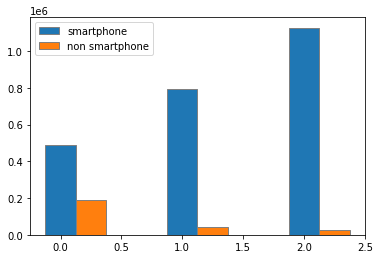

In [601]:
income_check_dt0 = demo_dt[['sm_index', 'deincome_followup3', 'hh_wt_final']][(demo_dt['deage']!=1)&(demo_dt['sm_index']==0)&(demo_dt['deincome_followup3']!=-2)].groupby(by=['deincome_followup3','sm_index']).sum()
income_check_dt0.reset_index(inplace=True)

income_check_dt1 = demo_dt[['sm_index', 'deincome_followup3', 'hh_wt_final']][(demo_dt['deage']!=1)&(demo_dt['sm_index']==1)&(demo_dt['deincome_followup3']!=-2)].groupby(by=['deincome_followup3', 'sm_index']).sum()
income_check_dt1.reset_index(inplace=True)

income_check_dt = demo_dt[['sm_index', 'deincome_followup3', 'hh_wt_final']][(demo_dt['deage']!=1)&(demo_dt['deincome_followup3']!=-2)].groupby(by=['deincome_followup3']).sum()
income_check_dt.reset_index(inplace=True)

barwidth = 0.25
br1 = np.arange(income_check_dt0.shape[0])
br2 = [x + barwidth for x in br1]

plt.bar(br1, income_check_dt1['hh_wt_final'].values, width=barwidth, 
       edgecolor = 'grey', label='smartphone')
plt.bar(br2, income_check_dt0['hh_wt_final'].values, width=barwidth, 
       edgecolor = 'grey', label='non smartphone')

plt.legend()

print('% of smartphones in income group', income_check_dt1['hh_wt_final'].values/income_check_dt['hh_wt_final'].values)

% of smartphones in income group [0.72079593 0.94851389 0.97069301]


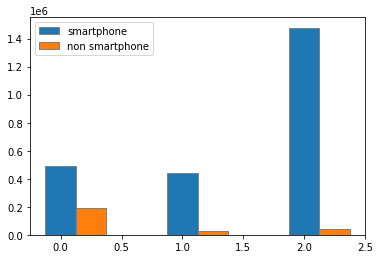

In [565]:
income_check_dt0pew = demo_dt[['sm_index', 'deincome_followup', 'hh_wt_final']][(demo_dt['deage']!=1)&(demo_dt['sm_index']==0)&(demo_dt['deincome_followup']!=-2)].groupby(by=['deincome_followup','sm_index']).sum()
income_check_dt0pew.reset_index(inplace=True)

income_check_dt1pew = demo_dt[['sm_index', 'deincome_followup', 'hh_wt_final']][(demo_dt['deage']!=1)&(demo_dt['sm_index']==1)&(demo_dt['deincome_followup']!=-2)].groupby(by=['deincome_followup', 'sm_index']).sum()
income_check_dt1pew.reset_index(inplace=True)

income_check_dtpew = demo_dt[['sm_index', 'deincome_followup', 'hh_wt_final']][(demo_dt['deage']!=1)&(demo_dt['deincome_followup']!=-2)].groupby(by=['deincome_followup']).sum()
income_check_dtpew.reset_index(inplace=True)

barwidth = 0.25
br1 = np.arange(income_check_dt0.shape[0])
br2 = [x + barwidth for x in br1]

plt.bar(br1, income_check_dt1['hh_wt_final'].values, width=barwidth, 
       edgecolor = 'grey', label='smartphone')
plt.bar(br2, income_check_dt0['hh_wt_final'].values, width=barwidth, 
       edgecolor = 'grey', label='non smartphone')

plt.legend()

print('% of smartphones in income group', income_check_dt1['hh_wt_final'].values/income_check_dt['hh_wt_final'].values)

In [415]:
demo_dt.columns

Index(['hhid', 'personid', 'sample_segment', 'age', 'gender', 'employment',
       'smartphone_type', 'smartphone_age', 'smartphone_qualified',
       'mobile_device', 'call_center', 'education', 'hh_wt_final', 'deage',
       'final_home_tract', 'final_home_bg', 'final_home_taz2010',
       'prev_home_taz2010', 'hhincome_detailed', 'hhincome_followup',
       'hhincome_broad', 'deincomepew', 'deincome_followup', 'sm_index'],
      dtype='object')

% of smartphones in income group [0.89675272 0.88761219]


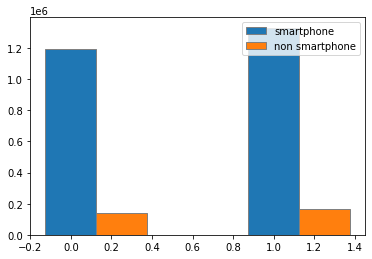

In [564]:
#gender check
#demo_dt['gender'] = demo_dt['gender'].replace(np.nan, -1)
#gender has no nan values
#demo_dt['gender'].describe()
gender_check_dt0 = demo_dt[['sm_index', 'gender', 'hh_wt_final']][(demo_dt['deage']!=1)&(demo_dt['sm_index']==0)&(demo_dt['gender'].isin([1,2]))].groupby(by=['gender','sm_index']).sum()
gender_check_dt0.reset_index(inplace=True)

gender_check_dt1 = demo_dt[['sm_index', 'gender', 'hh_wt_final']][(demo_dt['deage']!=1)&(demo_dt['sm_index']==1)&(demo_dt['gender'].isin([1,2]))].groupby(by=['gender', 'sm_index']).sum()
gender_check_dt1.reset_index(inplace=True)

gender_check_dt = demo_dt[['sm_index', 'gender', 'hh_wt_final']][(demo_dt['deage']!=1)&(demo_dt['gender'].isin([1,2]))].groupby(by=['gender']).sum()
gender_check_dt.reset_index(inplace=True)

barwidth = 0.25
br1 = np.arange(gender_check_dt0.shape[0])
br2 = [x + barwidth for x in br1]

plt.bar(br1, gender_check_dt1['hh_wt_final'].values, width=barwidth, 
       edgecolor = 'grey', label='smartphone')
plt.bar(br2, gender_check_dt0['hh_wt_final'].values, width=barwidth, 
       edgecolor = 'grey', label='non smartphone')

plt.legend()

print('% of smartphones in income group', gender_check_dt1['hh_wt_final'].values/gender_check_dt['hh_wt_final'].values)


In [603]:
age_per = age_check_dt1['hh_wt_final'].values/age_check_dt['hh_wt_final'].values
income_per = income_check_dt1['hh_wt_final'].values/income_check_dt['hh_wt_final'].values
gender_per = gender_check_dt1['hh_wt_final'].values/gender_check_dt['hh_wt_final'].values


In [567]:
income_per_pew = income_check_dt1pew['hh_wt_final'].values/income_check_dtpew['hh_wt_final'].values

In [604]:
income_per_pew

array([0.72079593, 0.94407019, 0.97138257])

In [605]:
income_per

array([0.72079593, 0.95084525, 0.97606382])

In [606]:
age_per_wyoung = np.hstack((0.53,age_per))

In [609]:
#data used for as prior info
percent_var_all_wyong = []
for i in gender_per:
    for j in age_per_wyoung:
        for k in income_per:
            percent_var_all_wyong.append(i*j*k)

percent_var_nogen_wyong = []
for j in age_per_wyoung:
    for k in income_per:
        percent_var_nogen_wyong.append(j*k)

print(list(np.round(np.array(percent_var_all_wyong), 7)))
print(list(np.round(np.array(percent_var_nogen_wyong), 7)))

[0.3425791, 0.4519167, 0.4639026, 0.6360929, 0.8391084, 0.8613635, 0.6176205, 0.8147403, 0.8363491, 0.5674873, 0.7486066, 0.7684614, 0.4494189, 0.5928555, 0.6085794, 0.3390872, 0.4473104, 0.4591741, 0.6296093, 0.8305554, 0.8525837, 0.6113251, 0.8064357, 0.8278242, 0.561703, 0.7409762, 0.7606285, 0.444838, 0.5868126, 0.6023762]
[0.3820218, 0.503948, 0.5173138, 0.7093292, 0.9357188, 0.9605362, 0.68873, 0.9085451, 0.9326418, 0.6328248, 0.8347972, 0.8569379, 0.5011626, 0.6611137, 0.678648]


In [610]:
prior_pew = [0.3581475,0.3829250,0.4324800,0.6487200,0.6936000,
             0.7833600,0.6419625,0.6863750,0.7752000,0.5608725,
             0.5996750,0.6772800,0.4122075,0.4407250,0.4977600,
             0.3581475,0.3829250,0.4324800,0.6487200,0.6936000,
             0.7833600,0.6419625,0.6863750,0.7752000,0.5608725,
             0.5996750,0.6772800,0.4122075,0.4407250,0.4977600]
prior_psrc_hh = [0.3425791, 0.4519167, 0.4639026, 0.6360929, 0.8391084, 
                 0.8613635, 0.6176205, 0.8147403, 0.8363491, 0.5674873,
                 0.7486066, 0.7684614, 0.4494189, 0.5928555, 0.6085794, 
                 0.3390872, 0.4473104, 0.4591741, 0.6296093, 0.8305554, 
                 0.8525837, 0.6113251, 0.8064357, 0.8278242, 0.561703, 
                 0.7409762, 0.7606285, 0.444838, 0.5868126, 0.6023762]

In [626]:
print((list(np.round(np.array(percent_var_all_wyong), 7))))

[0.3425791, 0.4519167, 0.4639026, 0.6360929, 0.8391084, 0.8613635, 0.6176205, 0.8147403, 0.8363491, 0.5674873, 0.7486066, 0.7684614, 0.4494189, 0.5928555, 0.6085794, 0.3390872, 0.4473104, 0.4591741, 0.6296093, 0.8305554, 0.8525837, 0.6113251, 0.8064357, 0.8278242, 0.561703, 0.7409762, 0.7606285, 0.444838, 0.5868126, 0.6023762]


prior comparison


Text(0, 0.5, 'prior: PEW')

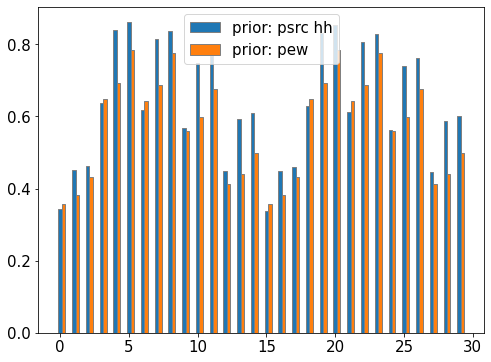

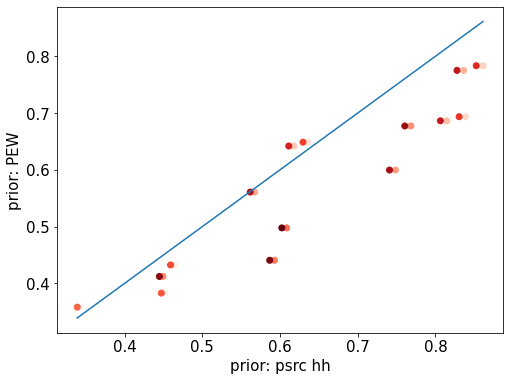

In [619]:
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams.update({'font.size': 15}) 

print('prior comparison')
barwidth = 0.25
br1 = np.arange(len(percent_var_all_wyong))
br2 = [x + barwidth for x in br1]

plt.bar(br1, percent_var_all_wyong, width=barwidth, 
       edgecolor = 'grey', label='prior: psrc hh')
plt.bar(br2, prior_pew, width=barwidth, 
       edgecolor = 'grey', label='prior: pew')

plt.legend()

#print('% of smartphones in income group', gender_check_dt1['hh_wt_final'].values/gender_check_dt['hh_wt_final'].values)

plt.rcParams["figure.figsize"] = (8,6)
x_val = list(range(0, 30))
fig = plt.figure()
ax1 = plt.subplot(111)
#ax1 = plt.subplot(121)
#ax2.set_title('estimated rate of demographic groups vs. actual per')
ax1.scatter(percent_var_all_wyong, prior_pew, c=x_val, cmap='Reds')
min_val = min(min(percent_var_all_wyong), min(prior_pew))
max_val = max(max(percent_var_all_wyong), max(prior_pew))
ax1.plot([min_val, max_val], [min_val, max_val])
#ax3.set_xticks(x_val, rotation=90)
#ax3.legend(bbox_to_anchor=(1.55, 1))
ax1.set_xlabel('prior: psrc hh')
ax1.set_ylabel('prior: PEW')

In [612]:
print(kstest(prior_pew, percent_var_all_wyong))
print(mannwhitneyu(prior_pew, percent_var_all_wyong))

KstestResult(statistic=0.26666666666666666, pvalue=0.23907300248018645)
MannwhitneyuResult(statistic=344.0, pvalue=0.1187404991999884)


In [536]:
#percentage comparison
#per in general
percent_var_all = []
for i in gender_per:
    for j in age_per:
        for k in income_per:
            percent_var_all.append(i*j*k)

percent_var_nogen = []
for j in age_per:
    for k in income_per:
        percent_var_nogen.append(j*k)

#data from PEW
#% of age under 18: .53
gender_pew = [.85, .85]
age_pew = [.96, .95, .83, .61]
income_pew = [(.76+.83)/2, .85, .96]
per_pewvar_all = []
for i in gender_pew:
    for j in age_pew:
        for k in income_pew:
            per_pewvar_all.append(i*j*k)

per_pewvar_nogen = []
for i in age_pew:
    for j in income_pew:
        per_pewvar_nogen.append(i*j)

In [529]:
np.round(np.array(percent_var_nogen), 7)

array([0.7093292, 0.9290516, 0.9559294, 0.68873  , 0.9020715, 0.9281688,
       0.6328248, 0.828849 , 0.852828 , 0.5011626, 0.6564031, 0.6753931])

In [481]:
np.arange(0, 1, 0.1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [488]:
min(min(per_pewvar_all), min(percent_var_all))

0.41220749999999995

In [524]:
def per_plot_scatter(per_psrc, per_pew, plotfit=True):
    N = len(per_psrc)
    x = per_psrc
    y = per_pew
    colors = np.arange(N)
    minval = min(min(x),min(y))
    maxval = max(max(x),max(y))
    a,b = np.polyfit(x, y, 1)
    
    xx = np.arange(minval, maxval+1/(N), 1/(N))
    
    plt.scatter(x, y, c=colors)
    plt.xlabel('PSRC HH data')
    plt.ylabel('PEW data')
    if plotfit == True:
        plt.plot(x, a*np.array(x)+b)
    plt.plot(xx, xx)
    print(a, b)
    plt.show()
    
    
def per_plot_bar(per_psrc, per_pew):
    #plt.figure(figurenum)
    br1 = np.arange(len(per_psrc))
    br2 = [x + barwidth for x in br1]
    
    plt.bar(br1, per_psrc, width=barwidth, 
       edgecolor = 'grey', label='PSRC HH data')
    plt.bar(br2, per_pew, width=barwidth, 
       edgecolor = 'grey', label='PEW data')
    plt.xlabel('demo group #')
    
    plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1))
    plt.show()
    

0.813692489271557 0.057899158019647005


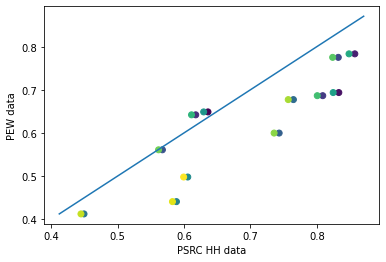

0.8547746716074452 0.0675752581190462


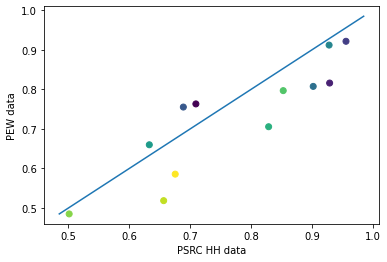

In [518]:
per_plot_scatter(percent_var_all, per_pewvar_all, False)
per_plot_scatter(percent_var_nogen, per_pewvar_nogen, False)

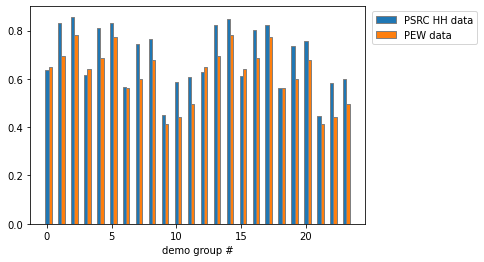

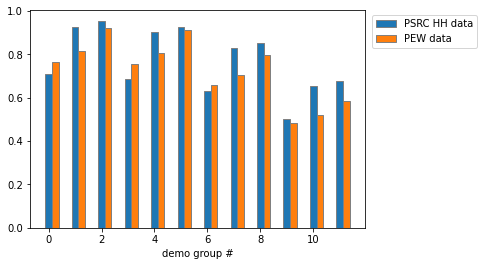

In [525]:
per_plot_bar(percent_var_all, per_pewvar_all)
per_plot_bar(percent_var_nogen, per_pewvar_nogen)

In [526]:
print('kstest per all', kstest(percent_var_all, per_pewvar_all))
print('kstest per noage', kstest(percent_var_nogen, per_pewvar_nogen))

print(mannwhitneyu(percent_var_all, per_pewvar_all))
print(mannwhitneyu(percent_var_nogen, per_pewvar_nogen))

kstest per all KstestResult(statistic=0.3333333333333333, pvalue=0.13982257948893737)
kstest per noage KstestResult(statistic=0.3333333333333333, pvalue=0.5360977695073805)
MannwhitneyuResult(statistic=370.0, pvalue=0.09275335462769208)
MannwhitneyuResult(statistic=86.0, pvalue=0.43573066003173655)


In [ ]:
#check the data with psrc survey with GPS
psrc_survey_path_GPS = 'G:\\My Drive\\2021\\Bias\\PSRC Spring 2017 Travel Survey\\2017-pr1-data-files-GPS\\'
os.chdir(psrc_survey_path_GPS)

hh_GPS = pd.read_excel('2017-pr1-R-1-household.xlsx', header=1)
hh_GPS.head(3)

#check the hhid, whether it is different in comparison with the 2017-pr1-data-file-GPS
#the hhid matches with the data w.o GPS
for i in hh_GPS.hhid:
    if i not in hh.hhid.values:
        print(i)

del(hh_GPS)

In [50]:
psrc_od_simulation = 'G:\\My Drive\\2021\\Bias\\PSRC_od_simulation_2018\\'
os.chdir(psrc_od_simulation)

demo_group = pd.read_csv('demo_group_dt_revised.csv')
demo_group.head(3)

,Unnamed: 0,TAZ,demo_level_1,demo_level_2,demo_level_3,demo_level_4,demo_level_5,demo_level_6,demo_level_7,demo_level_8,...,demo_level_30,appid_count,COUNTY_FIP,COUNTY_NM,Area,geometry,TAZ1,psrc_sum,sumup_psrc_demo,sum_demo_rate
0,0,1,2,96,15,0,16,0,3,94,...,3,17,33,King,7117998.770,POLYGON ((-122.3609440013541 47.72733999996547...,1,980,980,0.017347
1,1,2,38,165,2,19,61,4,32,206,...,0,30,33,King,488714.265,POLYGON ((-122.3555520013541 47.72504799996551...,2,1720,1720,0.017442
2,2,3,39,46,0,82,155,0,99,183,...,0,66,33,King,503192.772,"POLYGON ((-122.3555720013543 47.7341289999656,...",3,2699,2691,0.024526


In [64]:
demo_group[demo_group['TAZ'].isin(hh.final_home_taz2010.values)].shape

(1004, 41)

In [63]:
hh[hh['final_home_taz2010'].isin(demo_group.TAZ.values)].shape

(3189, 7)

In [ ]:
#check missings from psrc survey in comparison with entire psra
check_ingis = ''
for i in np.unique(hh.final_home_taz2010):
    check_ingis = check_ingis+str(i)+','
#print(check_ingis)   

#check missings from the sim data 
demo_group.TAZ
check_ingis = ''
for i in np.unique(demo_group.TAZ):
    check_ingis = check_ingis+str(i)+','

In [83]:
person    

,hhid,personid,sample_segment,age,gender,employment,education
0,17100005,1710000501,23,9,2,3.0,7.0
1,17100005,1710000502,23,10,1,6.0,3.0
2,17100024,1710002401,51,6,3,2.0,7.0
3,17100024,1710002402,51,6,2,1.0,7.0
4,17100024,1710002403,51,1,4,NaN,NaN
...,...,...,...,...,...,...,...
6249,17154152,1715415201,55,7,1,3.0,6.0
6250,17154152,1715415202,55,8,2,1.0,7.0
6251,17154152,1715415203,55,2,2,NaN,NaN
6252,17154199,1715419901,12,7,2,1.0,6.0


'1,2,3,4,5,6,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,231,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,254,256,257,258,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286